In [2]:
VERSION

v"1.8.4"

In [3]:
pwd()

"/Users/masanorikanamaru/Documents/GitHub/Astroshaper"

In [4]:
ENV["COLUMNS"] = 1000
ENV["LINES"] = 20;

In [5]:
# using Pkg
# module_name = "JLD2"
# Pkg.add(module_name)
# Pkg.update(module_name)
# Pkg.build(module_name)

In [7]:
using GLMakie
using JLD2

using Revise
using Astroshaper
import SPICE

# Load SPICE kernels

In [8]:
meta_kernel = "/Users/masanorikanamaru/Dropbox/spice/hera/kernels/mk/hera_study_PO_EMA_2024_shapeViewer.tm"

SPICE.furnsh(meta_kernel)

# Thermophysical Simulation

## Based on a shape model newly loaded

In [10]:
shapedir = "/Users/masanorikanamaru/Dropbox/spice/hera/kernels/dsk"

shapepath1 = joinpath(shapedir, "g_50677mm_rad_obj_dida_0000n00000_v001.obj")
shapepath2 = joinpath(shapedir, "g_06650mm_rad_obj_didb_0000n00000_v001.obj")

shape1 = ShapeModel(shapepath1; scale=1000, find_visible_facets=true, save_shape=false)
shape2 = ShapeModel(shapepath2; scale=1000, find_visible_facets=true, save_shape=false);

In [15]:
println(shape1)
println(shape2)

Shape model
-----------
Nodes             : 1000
Faces             : 1996
Surface area      : 1.9587914739775863e6
Volume            : 2.485481753075182e8
Equivalent radius : 390.03836143582186
Maximum radius    : 427.5183409578403
Minimum radius    : 352.28283811149896
Center-of-Figure  : [2.484674354494825e-6, -2.0997384259416257e-6, 2.190089591373722e-6]
Inertia tensor    : 
    | Ixx Ixy Ixz |   [0.0, 0.0, 0.0]
    | Iyx Iyy Iyz | = [0.0, 0.0, 0.0]
    | Izx Izy Izz |   [0.0, 0.0, 0.0]

Shape model
-----------
Nodes             : 1538
Faces             : 3072
Surface area      : 53920.63065752515
Volume            : 1.1314114665400542e6
Equivalent radius : 64.64138537338498
Maximum radius    : 82.0000022649765
Minimum radius    : 52.499998360872304
Center-of-Figure  : [2.009646200056278e-16, 3.5852088209004e-16, -2.9131831316015805e-15]
Inertia tensor    : 
    | Ixx Ixy Ixz |   [0.0, 0.0, 0.0]
    | Iyx Iyy Iyz | = [0.0, 0.0, 0.0]
    | Izx Izy Izz |   [0.0, 0.0, 0.0]



In [17]:
et_bgn_str = "2027-02-10T00:00:00"
et_end_str = "2027-02-11T00:00:00"

et_bgn = SPICE.utc2et(et_bgn_str)
et_end = SPICE.utc2et(et_end_str)
step   = 300

et_range = et_bgn:step:et_end

@show et_range
@show length(et_range);

et_range = 8.554896691849976e8:300.0:8.555760691849976e8
length(et_range) = 289


In [22]:
sun_d1 = spkpos("SUN",       et_range, "DIDYMOS_FIXED",   "None", "DIDYMOS")
sun_d2 = spkpos("SUN",       et_range, "DIMORPHOS_FIXED", "None", "DIMORPHOS")
d1_d2  = spkpos("DIDYMOS",   et_range, "DIMORPHOS_FIXED", "None", "DIMORPHOS")
d2_d1  = spkpos("DIMORPHOS", et_range, "DIDYMOS_FIXED",   "None", "DIDYMOS");

In [23]:
D1_TO_D2 = pxform("DIDYMOS_FIXED",   "DIMORPHOS_FIXED", et_range)
D2_TO_D1 = pxform("DIMORPHOS_FIXED", "DIDYMOS_FIXED",   et_range)

D1_TO_J2000 = pxform("DIDYMOS_FIXED",   "J2000", et_range)
D2_TO_J2000 = pxform("DIMORPHOS_FIXED", "J2000", et_range);

In [28]:
thermo_params = ThermoParams(  # [Michel+2016; Naidu+2020]
    A_B   = 0.059,  # Bolometric Bond albedo
    A_TH  = 0.0,
    k     = 0.125,
    ρ     = 2170.,
    Cp    = 600.,
    ϵ     = 0.9,
    t_bgn = et_range[begin],
    t_end = et_range[end],
    Nt    = length(et_range),
    z_max = 0.6,
    Nz    = 41,
    P     = SPICE.convrt(DIDYMOS[:P], "hours", "seconds"),
);

In [29]:
dirpath_result = "/Users/masanorikanamaru/Dropbox/Hera/TPM-Binary"
dirpath_result = joinpath(dirpath_result, "TPM-Binary_v2022-12-10_" * replace(et_bgn_str * "_" * et_end_str, ":" => "-"))
filepath_result = joinpath(dirpath_result, "TPM_result.jld2")

dirpath_temp_maps = joinpath(dirpath_result, "temp_maps")

# mkdir(dirpath_result)
# mkdir(dirpath_temp_maps)

"/Users/masanorikanamaru/Dropbox/Hera/TPM-Binary/TPM-Binary_v2022-12-10_2027-02-10T00-00-00_2027-02-11T00-00-00/temp_maps"

Initialize temperature distirbution

In [30]:
init_temps_zero!(shape1, thermo_params)
init_temps_zero!(shape2, thermo_params)

Run thermophysical simulation
- 保存データの形式を検討する
- 保存データを指定できるようにする
- ひとまず辞書型の中にVectorやMatrixとして保持するか

In [31]:
shapes = (shape1, shape2)
suns = (sun_d1, sun_d2)
run_TPM!(shapes, et_range, suns, D2_TO_D1, d2_d1, thermo_params, filepath_result, [:surf_temps, :forces, :torques])

In [53]:
# jldopen(savepath, "r+") do file
#     file["D2_TO_J2000"] = D2_TO_J2000[save_range]
# end;

Load TPM result

In [32]:
data = load(filepath_result)
keys(data)

KeySet for a Dict{String, Any} with 8 entries. Keys:
  "et_range"
  "suns"
  "S2P"
  "thermo_params"
  "forces"
  "shapes"
  "surf_temps"
  "torques"

Max. temperature: 312.3062158087901
Min. temperature: 0.0


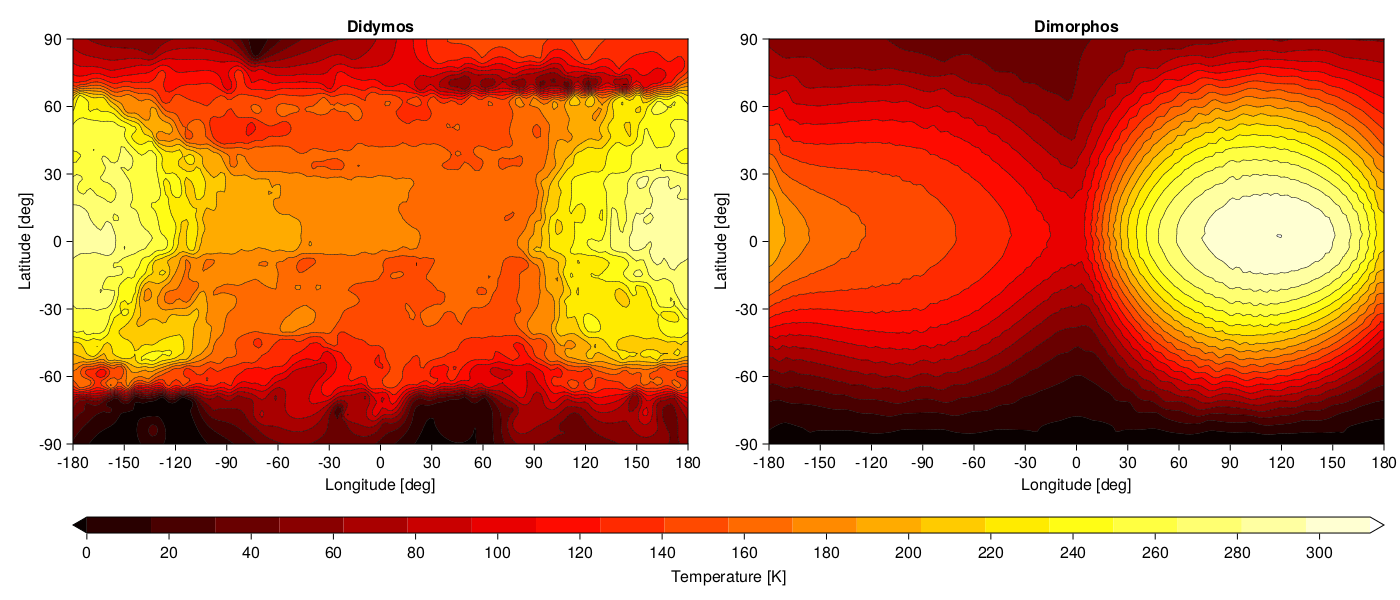

In [33]:
temperature_map(data["shapes"]...;
    nlevels=20,
    titles=("Didymos", "Dimorphos"),
    filepath=joinpath(dirpath_result, "temp_maps_final.pdf")
)

In [31]:
# for (i, et) in enumerate(data["et_range"])
#     temps1 = data["surf_temps"][1][:, i]
#     temps2 = data["surf_temps"][2][:, i]
#     filename = "temp_maps_" * string(et) * ".pdf"
#     filepath = joinpath(dirpath_temp_maps, filename)
#     titles = (
#         "Didymos: "   * SPICE.et2utc(et, "C", 0),
#         "Dimorphos: " * SPICE.et2utc(et, "C", 0),
#     )
#     temperature_map(data["shapes"]...; temps1, temps2, colorrange=(0,350), nlevels=20, filepath, titles)
# end

## Based on a result already saved

In [15]:
dirpath_result = "/Users/masanorikanamaru/Dropbox/Hera/TPM-Binary"
dirpath_result = joinpath(dirpath_result, "TPM-Binary_v20221107_2027-02-09T00-00-00_2027-02-18T00-00-00")
filepath_result = joinpath(dirpath_result, "TPM_result.jld2")

shapes = load(filepath_result, "shapes");

┌ Warning: the following fields are present in type ShapeModel{Int64, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Int64}}, StructArrays.StructVector{Astroshaper.Facet{StaticArraysCore.SVector{3, Float64}, Float64, StructArrays.StructVector{Astroshaper.VisibleFacet, NamedTuple{(:id, :f, :d, :d̂), Tuple{Vector{Int64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, Float64}}}}, Int64}, Astroshaper.Flux{Float64}, Vector{Float64}, Vector{Float64}}, NamedTuple{(:A, :B, :C, :center, :normal, :area, :visiblefacets, :flux, :temps, :_temps_, :force), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{Float64}, Vector{StructArrays.StructVector{Astroshaper.VisibleFacet, NamedTuple{(:id, :f, :d, :d̂), Tuple{Vector{Int64}, Vector{Float64}, Vector{Float6

In [19]:
et_bgn_str = "2027-02-18T00:00:00"
et_end_str = "2027-02-19T00:00:00"

et_bgn = SPICE.utc2et(et_bgn_str)
et_end = SPICE.utc2et(et_end_str)
step   = 10

et_range = et_bgn:step:et_end
 
@show et_range
@show length(et_range);

et_range = 8.561808691851717e8:10.0:8.562672691851717e8
length(et_range) = 8641


In [20]:
sun_d1 = spkpos("SUN",       et_range, "DIDYMOS_FIXED",   "None", "DIDYMOS")
sun_d2 = spkpos("SUN",       et_range, "DIMORPHOS_FIXED", "None", "DIMORPHOS")
d1_d2  = spkpos("DIDYMOS",   et_range, "DIMORPHOS_FIXED", "None", "DIMORPHOS")
d2_d1  = spkpos("DIMORPHOS", et_range, "DIDYMOS_FIXED",   "None", "DIDYMOS");

In [21]:
D1_TO_D2 = pxform("DIDYMOS_FIXED",   "DIMORPHOS_FIXED", et_range)
D2_TO_D1 = pxform("DIMORPHOS_FIXED", "DIDYMOS_FIXED",   et_range)

D1_TO_J2000 = pxform("DIDYMOS_FIXED",   "J2000", et_range)
D2_TO_J2000 = pxform("DIMORPHOS_FIXED", "J2000", et_range);

In [22]:
thermo_params = ThermoParams(  # [Michel+2016; Naidu+2020]
    A_B   = 0.059,  # Bolometric  Bond albedo
    A_TH  = 0.0,
    k     = 0.125,
    ρ     = 2170.,
    Cp    = 600.,
    ϵ     = 0.9,
    t_bgn = et_range[begin],
    t_end = et_range[end],
    Nt    = length(et_range),
    z_max = 0.6,
    Nz    = 41,
    P     = SPICE.convrt(DIDYMOS[:P], "hours", "seconds"),
);

In [24]:
savedir = joinpath(dirpath_result, "TPM-Binary_v20221107_" * replace(et_bgn_str * "_" * et_end_str, ":" => "-"))
# mkdir(savedir)

savepath = joinpath(savedir, "TPM_result.jld2")

"/Users/masanorikanamaru/Dropbox/Hera/TPM-Binary/TPM-Binary_v20221107_2027-02-09T00-00-00_2027-02-18T00-00-00/TPM-Binary_v20221107_2027-02-18T00-00-00_2027-02-19T00-00-00/TPM_result.jld2"

In [72]:
suns = (sun_d1, sun_d2)
run_TPM!(shapes, et_range, suns, D2_TO_D1, d2_d1, thermo_params, savepath)

# jldopen(savepath, "r+") do file
#     file["D2_TO_J2000"] = D2_TO_J2000
# end;

In [63]:
data = load(savepath)
keys(data)

┌ Warning: the following fields are present in type ShapeModel{Int64, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Int64}}, StructArrays.StructVector{Astroshaper.Facet{StaticArraysCore.SVector{3, Float64}, Float64, StructArrays.StructVector{Astroshaper.VisibleFacet, NamedTuple{(:id, :f, :d, :d̂), Tuple{Vector{Int64}, Vector{Float64}, Vector{Float64}, Vector{StaticArraysCore.SVector{3, Float64}}}}, Int64}, Astroshaper.Flux{Float64}, Vector{Float64}, Vector{Float64}}, NamedTuple{(:A, :B, :C, :center, :normal, :area, :visiblefacets, :flux, :temps, :_temps_, :force), Tuple{Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{StaticArraysCore.SVector{3, Float64}}, Vector{Float64}, Vector{StructArrays.StructVector{Astroshaper.VisibleFacet, NamedTuple{(:id, :f, :d, :d̂), Tuple{Vector{Int64}, Vector{Float64}, Vector{Float6

KeySet for a Dict{String, Any} with 8 entries. Keys:
  "et_range"
  "suns"
  "S2P"
  "thermo_params"
  "forces"
  "shapes"
  "surf_temps"
  "torques"

In [12]:
# temperature_map(data["shapes"]...; nlevels=20, titles=("Didymos", "Dimorphos"), filepath="tmp/temp_maps.pdf")

In [26]:
# dirpath_temp_maps = joinpath(savedir, "temp_maps")
# mkpath(dirpath_temp_maps)

# for (i, et) in enumerate(data["et_range"])
#     temps1 = data["surf_temps"][1][:, i]
#     temps2 = data["surf_temps"][2][:, i]
#     filename = "temp_maps_" * string(et) * ".pdf"
#     filepath = joinpath(dirpath_temp_maps, filename)
#     titles = (
#         "Didimos: "   * SPICE.et2utc(et, "C", 0),
#         "Dimorphos: " * SPICE.et2utc(et, "C", 0),
#     )
#     temperature_map(data["shapes"]...; temps1, temps2, colorrange=(0,350), nlevels=20, filepath, titles)
# end

In [35]:
# data["forces"][1]
# data["forces"][2]

# data["torques"][1]
# data["torques"][2]

In [68]:
data["torques"][2]

8641-element Vector{Vector{Float64}}:
 [-0.011939985146416124, 0.00932615013373194, -0.044901148823540106]
 [-0.011940567687199546, 0.009344489092752147, -0.044959880918332286]
 [-0.011934888704691348, 0.009384886683468536, -0.04506870402783117]
 [-0.011929259319334378, 0.009424898776720595, -0.04517701302281376]
 [-0.011923625679403463, 0.009464811825228766, -0.04528503586036053]
 [-0.011917972764353052, 0.009504715076001558, -0.045392805204227726]
 [-0.011912204738308415, 0.009544936413376103, -0.04550014125518681]
 [-0.011906356474008192, 0.00958539188071785, -0.04560701883543577]
 ⋮
 [-0.011894392806203045, 0.012193749074954463, -0.05066790186545291]
 [-0.01188690193235868, 0.012234779889863283, -0.0507520582579963]
 [-0.011879390962339323, 0.0122757981456803, -0.05083592061558338]
 [-0.01187186052766808, 0.012316793738083065, -0.050919488336136215]
 [-0.011864311275652293, 0.012357757812217323, -0.051002760867018646]
 [-0.011856742002996936, 0.01239870904081364, -0.051085738334130

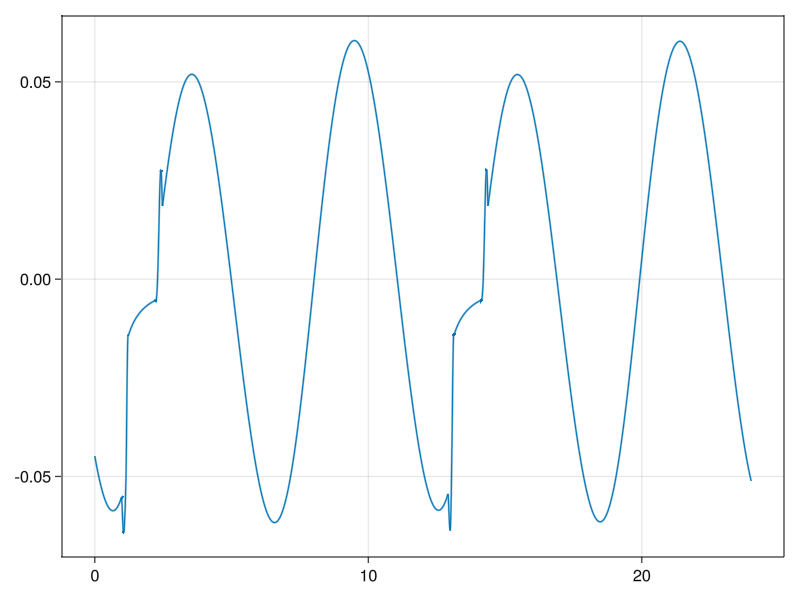

In [67]:
ts = @. (data["et_range"] - data["et_range"][begin]) / 3600
lines(ts, [τ[3] for τ in data["torques"][2]])

In [51]:
τ̄₂ = Astroshaper.mean(τ[3] for τ in data["torques"][2])

-0.0004834155776402737

In [52]:
m₂ = 2.446984953097128e9
R₂ = 65
C₂ = 2/5 * m₂ * R₂^2

4.1354045707341465e12

In [53]:
P₂ = 12 * 3600
ω₂ = 2π / P₂

0.0001454441043328608

In [57]:
t_acc = C₂ * ω₂ / τ̄₂
SPICE.convrt(t_acc, "seconds", "years")

-39426.61725313366

In [39]:
SPICE.kclear()

In [21]:
# draw(shape1; data=:temperature, colormap=:vik)
# draw(shape2; data=:temperature, colormap=:vik)

# Temperature Map

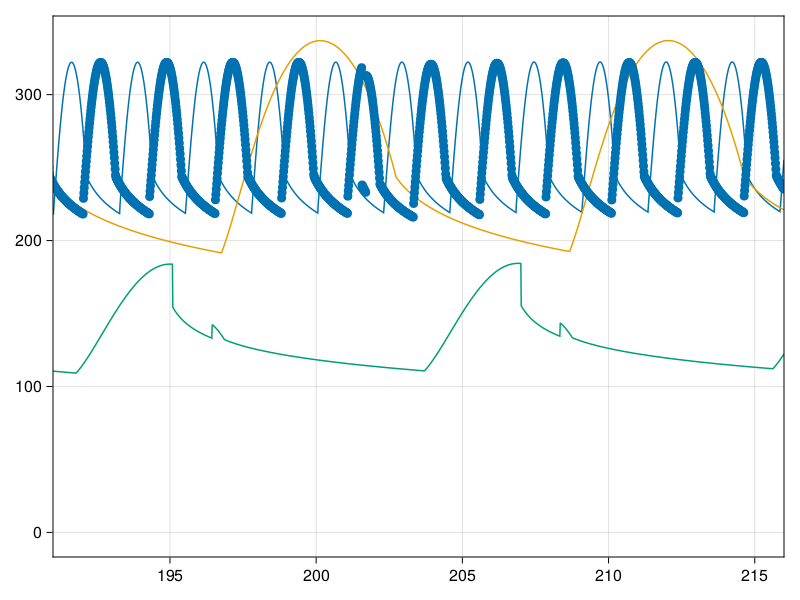

In [94]:
fig = Figure()
ax = Axis(fig[1, 1])

ts = @. (data["et_range"] - data["et_range"][begin]) / 3600

lines!(ts, data["surf_temps"][1][302, :])  # At equator
lines!(ts, data["surf_temps"][2][528, :])  # At equator

scatter!(ts, data["surf_temps"][1][600, :])
# lines!(ts, data["surf_temps"][2][1000, :])
lines!(ts, data["surf_temps"][2][3000, :])

xlims!(191, 216)
# xlims!(201, 203)
# ylims!(150, 350)

display(fig)

In [3]:
# temps1 = data["surf_temps"][1][:, 114]
# temperature_map(shape1, temps1; nlevels=10, title="Didymos", filepath="tmp/temp_map_Didymos.pdf")

In [2]:
# temps2 = data["surf_temps"][2][:, 114]
# temperature_map(shape2, temps2; nlevels=10, title="Dimorphos", filepath="tmp/temp_map_Dimorphos.pdf")

Max. temperature: 337.2467841929806
Min. temperature: 0.0


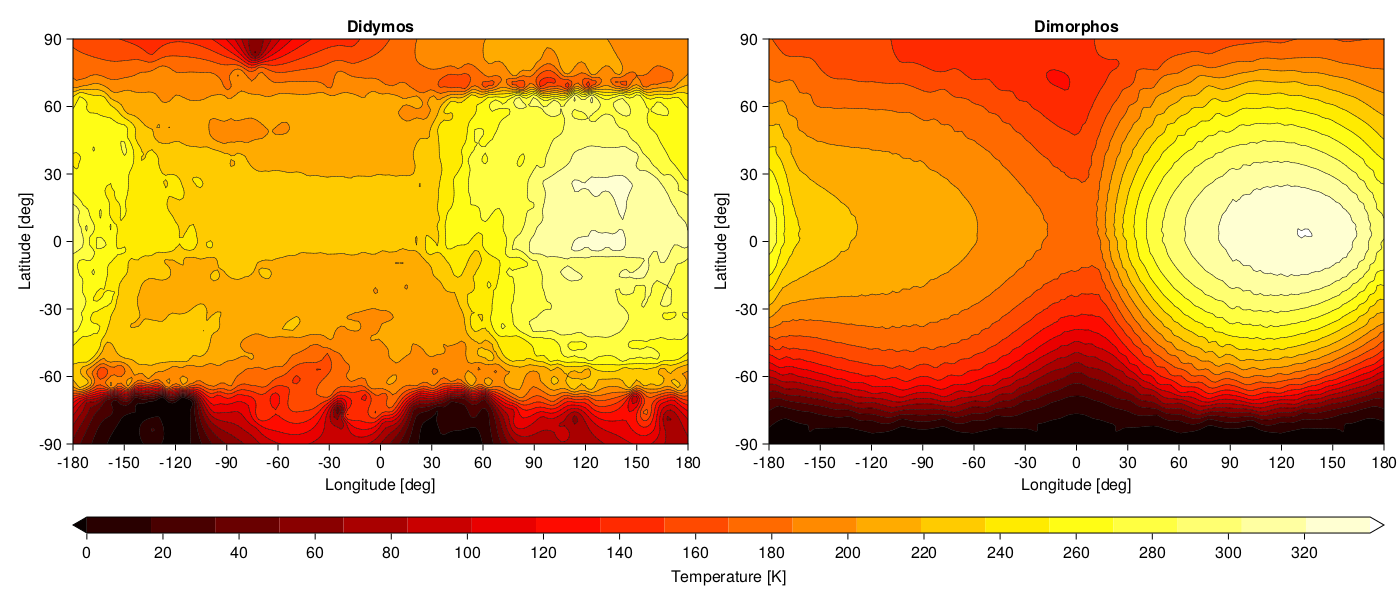

In [95]:
temps1 = data["surf_temps"][1][:, end]
temps2 = data["surf_temps"][2][:, end]
temperature_map(data["shapes"]..., temps1, temps2; nlevels=20, titles=("Didymos", "Dimorphos"), filepath="tmp/temp_maps.pdf")

In [40]:
# draw(shape1; data=temps1, colormap=:hot, strokewidth=0)
# draw(shape2; data=temps2, colormap=:hot, strokewidth=0)

In [42]:
meta_kernel = "/Users/masanorikanamaru/Dropbox/spice/hera/kernels/mk/hera_study_PO_EMA_2024_shapeViewer.tm"

SPICE.furnsh(meta_kernel)

In [44]:
# for (i, et) in enumerate(data["et_range"])
#     temps1 = data["surf_temps"][1][:, i]
#     temps2 = data["surf_temps"][2][:, i]
#     filepath = "./tmp/temp_maps/temp_maps_" * string(et) * ".png"
#     titles = (
#         "Didimos: "   * SPICE.et2utc(et, "C", 0),
#         "Dimorphos: " * SPICE.et2utc(et, "C", 0),
#     )
#     temperature_map(shape1, shape2, temps1, temps2; colorrange=(0,350), nlevels=10, filepath, titles)
# end

In [179]:
SPICE.kclear()

# Analysis of Temperature Change

- どれくらいの撮像間隔なら熱物性値を決められるか？

In [53]:
filepath = "/Users/masanorikanamaru/Dropbox/Hera/TPM/temp_maps_2027-02-09T22-00-00_2027-02-18T22-00-00/temp_maps.jld2"
data = load(filepath)
keys(data)

KeySet for a Dict{String, Any} with 8 entries. Keys:
  "et_range"
  "suns"
  "S2P"
  "thermo_params"
  "forces"
  "shapes"
  "surf_temps"
  "torques"

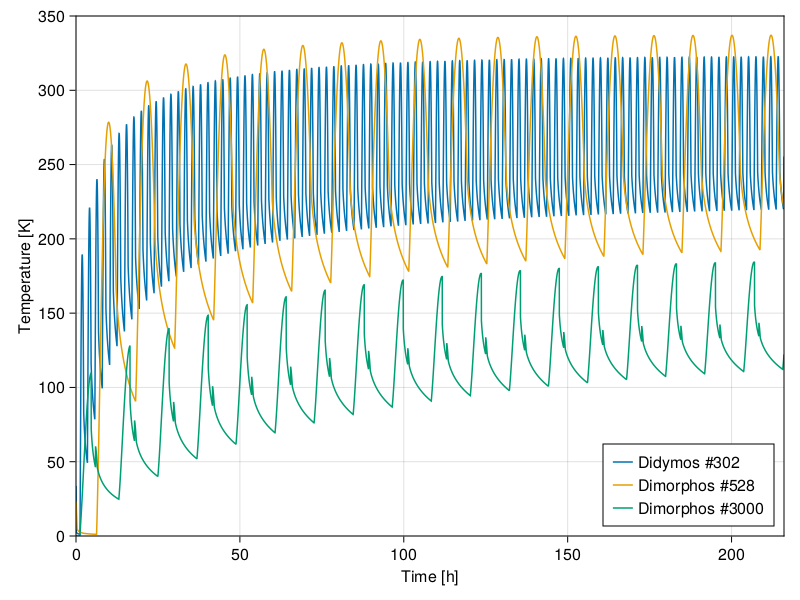

In [71]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Time [h]", ylabel="Temperature [K]")

ts = @. (data["et_range"] - data["et_range"][begin]) / 3600

lines!(ts, data["surf_temps"][1][302, :], label="Didymos #302")      # At equator
lines!(ts, data["surf_temps"][2][528, :], label="Dimorphos #528")    # At equator
lines!(ts, data["surf_temps"][2][3000, :], label="Dimorphos #3000")  # At equator (Eclipse can be observed)

xlims!(0, 216)
ylims!(0, 350)

axislegend(ax, position=:rb)
save("tmp.pdf", fig)
display(fig)

In [55]:
selected = @. data["et_range"] > data["et_range"][end] - 3600*24;

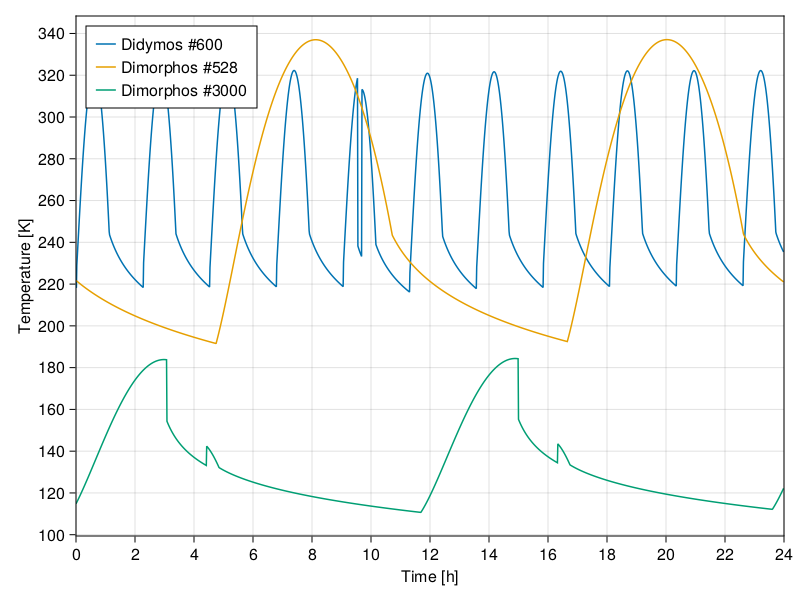

In [87]:
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Time [h]", ylabel="Temperature [K]", xticks=0:2:24, yticks=0:20:500)

ts = @. (data["et_range"][selected] - data["et_range"][selected][begin]) / 3600

# lines!(ts, data["surf_temps"][1][302,  selected], label="Didymos #302")     # At equator
lines!(ts, data["surf_temps"][1][600,  selected], label="Didymos #600")     # At equator (Eclipse can be observed)
lines!(ts, data["surf_temps"][2][528,  selected], label="Dimorphos #528")   # At equator
lines!(ts, data["surf_temps"][2][3000, selected], label="Dimorphos #3000")  # At equator (Eclipse can be observed)

xlims!(0, 24)
# xlims!(9.5, 9.8)
# xlims!(14, 18)
# ylims!(0, 350)

axislegend(ax, position=:lt)
save("tmp.pdf", fig)
display(fig)